# Library Install and Drive Path Settings

In [ ]:
from google.colab import drive
drive_name = '/content/drive'
drive.mount(drive_name)
fpG2W = drive_name + '/My Drive/ProjectData/gene2vec_dim_200_iter_9_w2v.txt'
pfp = drive_name + '/My Drive/ProjectData/'
data_path = pfp + "DG-AssocMiner_miner-disease-gene.tsv"

Mounted at /content/drive


In [ ]:
import torch
import os
print("PyTorch has version {}".format(torch.__version__))
print(torch.version.cuda)

In [ ]:
! pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.11.0+cu113.html
! pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.11.0+cu113.html
! pip install -q torch-geometric

In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import random
import string
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_geometric.transforms as T
from torch_geometric.data import Data, download_url, extract_gz
from plotly import graph_objs as go
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.model_selection import ParameterGrid
from torch_geometric.data import Data
from torch_geometric.nn import GAE,GCNConv,ARMAConv,SGConv,FeaStConv,HypergraphConv,DenseGCNConv,DenseSAGEConv,ChebConv,SAGEConv,GATConv,GraphConv,VGAE
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import train_test_split_edges, negative_sampling, degree


In [ ]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

In [ ]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [ ]:
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

import networkx as nx
from gensim.models import Word2Vec

from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph
from stellargraph import datasets
from IPython.display import display, HTML

%matplotlib inline

Also, set the seeds for this colab for reproducibility.

In [ ]:
# set the seeds
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

# Read Edge List and Construct Edge_Index

In [ ]:
# Read and Show The Edgelist Data.
# Note that column names are ["# Disease ID", "Disease Name", "Gene ID"].
df = pd.read_csv(data_path, sep="\t")
print(df.head(), '\n')

  # Disease ID              Disease Name  Gene ID
0     C0036095  Salivary Gland Neoplasms     1462
1     C0036095  Salivary Gland Neoplasms     1612
2     C0036095  Salivary Gland Neoplasms      182
3     C0036095  Salivary Gland Neoplasms     2011
4     C0036095  Salivary Gland Neoplasms     2019 



Assigning unique integer index to the 519 disease nodes and 7294 gene nodes to be indexed 519 through 7812.

The edge list should be transposed to edge_index for storing the data as a data object.
Also all edges accepted as undirected so reverse edges are added

In [ ]:
def load_node_mapping(datafile_path, index_col, offset=0):
  """
  Maps each distinct node to a unique integer index.

  Args: datafile_path, string name of the tsv file containing the graph data
        index_col, string name of the column containing the nodes of concern
        offset, amount to shift the generated indexes by
  Returns: the mapping from node name to integer index
  """
  df = pd.read_csv(datafile_path, index_col=index_col, sep="\t")
  mapping = {index_id: i + offset for i, index_id in enumerate(df.index.unique())}
  return mapping

def load_edge_list(datafile_path, src_col, src_mapping, dst_col, dst_mapping):
  """
  Given node mappings, returns edge list in terms of node integer indices.

  Args: datafile_path, string name of the tsv file containing the graph data
        src_col, string name of the column corresponding to source nodes
        src_mapping, mapping from source node name to integer index
  Returns: the mapping from node name to integer index
  """
  df = pd.read_csv(datafile_path, sep="\t")
  src_nodes = [src_mapping[index] for index in df[src_col]]
  dst_nodes = [dst_mapping[index] for index in df[dst_col]]
  edge_index = torch.tensor([src_nodes, dst_nodes])
  return edge_index

def initialize_data(datafile_path, num_features=1):
  """
  Given a tsv file specifying disease-gene interactions, index the nodes and
  construct a Data object.
  """
  # Get disease node mapping and gene node mapping.
  # Each node type has its own set of integer ids.
  dz_col, gene_col = "# Disease ID", "Gene ID"
  dz_mapping = load_node_mapping(datafile_path, dz_col, offset=0)
  gene_mapping = load_node_mapping(datafile_path, gene_col, offset=519)

  # Get edge index in terms of the integer indeces assigned to the nodes.
  edge_index = load_edge_list(
      datafile_path, dz_col, dz_mapping, gene_col, gene_mapping)

  # Add the reverse direction (aka make it a undirected graph)
  rev_edge_index = load_edge_list(
      datafile_path, gene_col, gene_mapping, dz_col, dz_mapping)

  # Construct a Data object.
  data = Data()
  data.num_nodes = len(dz_mapping) + len(gene_mapping)
  data.edge_index = torch.cat((edge_index, rev_edge_index), dim=1)
  data.x = torch.ones(data.num_nodes, num_features)
  return data, gene_mapping, dz_mapping

# Initialize the Data Object

In [ ]:
#@title Dataset Configuration

NUM_FEATURES =   128#@param {type: "integer"}

In [ ]:
# Read data and construct Data object.
data_object, gene_mapping, dz_mapping = initialize_data(data_path, NUM_FEATURES)
## data_object.x = torch.Tensor(n2v_embeddings)
print("Number of features:", NUM_FEATURES)
print(data_object)
print("Number of genes:", len(gene_mapping))
print("Number of diseases:", len(dz_mapping))

Number of features: 128
Data(num_nodes=7813, edge_index=[2, 42714], x=[7813, 128])
Number of genes: 7294
Number of diseases: 519


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

# Node2Vec for Feature Embedings

I read the graph with networkx
Then create StellarGraph from Networkx Graph

# RandomWalk Step of Node2Vec Algorithm

In [ ]:
"""
GA = nx.read_edgelist(pfp+"DG-AssocMiner_miner-disease-gene.tsv", create_using = nx.Graph())
G = StellarGraph.from_networkx(GA)
rw = BiasedRandomWalk(G)

walks = rw.run(
    nodes=list(G.nodes()),  # root nodes
    length=100,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
)
print("Number of random walks: {}".format(len(walks)))
"""

'\nGA = nx.read_edgelist(pfp+"DG-AssocMiner_miner-disease-gene.tsv", create_using = nx.Graph())\nG = StellarGraph.from_networkx(GA)\nrw = BiasedRandomWalk(G)\n\nwalks = rw.run(\n    nodes=list(G.nodes()),  # root nodes\n    length=100,  # maximum length of a random walk\n    n=10,  # number of random walks per root node\n    p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node\n    q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node\n)\nprint("Number of random walks: {}".format(len(walks)))\n'

# Word2Vec Step for creating Embeddings

In [ ]:
"""
str_walks = [[str(n) for n in walk] for walk in walks]
model = Word2Vec(str_walks, size=128, window=5, min_count=0, sg=1, workers=2, iter=1)
torch.save(model.wv,f = pfp + "w2v128_01")
"""

'\nstr_walks = [[str(n) for n in walk] for walk in walks]\nmodel = Word2Vec(str_walks, size=128, window=5, min_count=0, sg=1, workers=2, iter=1)\ntorch.save(model.wv,f = pfp + "w2v128_01")\n'

Switching to integer indexes as Key of Embedding Dictionary
To comply with our node_id handling for Edge_Index

In [ ]:
"""
n2v_embeddings = {}
for node_id, node_index in dz_mapping.items():
  n2v_embeddings[node_index] = model.wv[node_id]
for node_id, node_index in gene_mapping.items():
  n2v_embeddings[node_index] = model.wv[str(node_id)]
torch.save(n2v_embeddings,f = pfp + "n2v128_01")
"""
n2v_embeddings = torch.load(pfp + "n2v128_01")

In [ ]:
for k in range(len(n2v_embeddings)):
  data_object.x[k] = torch.tensor(n2v_embeddings[k])

# Split data_object into Train/Validation/Test DataSets
Construct the dataset splits for the selected dataset. We are chooing 15% of the edges to be test edges, and about 5% of the edges as validation edges.

In [ ]:
transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.15, is_undirected=True,
                      split_labels=True, add_negative_train_samples=True),
])

train_dataset, val_dataset, test_dataset = transform(data_object)
print("Train Data:\n", train_dataset)
print("Validation Data:\n", val_dataset)
print("Test Data:\n", test_dataset)

Train Data:
 Data(num_nodes=7813, edge_index=[2, 34174], x=[7813, 128], pos_edge_label=[17087], pos_edge_label_index=[2, 17087], neg_edge_label=[17087], neg_edge_label_index=[2, 17087])
Validation Data:
 Data(num_nodes=7813, edge_index=[2, 34174], x=[7813, 128], pos_edge_label=[1067], pos_edge_label_index=[2, 1067], neg_edge_label=[1067], neg_edge_label_index=[2, 1067])
Test Data:
 Data(num_nodes=7813, edge_index=[2, 36308], x=[7813, 128], pos_edge_label=[3203], pos_edge_label_index=[2, 3203], neg_edge_label=[3203], neg_edge_label_index=[2, 3203])


# Utility functions

In [ ]:
def get_mapping():

  df = pd.read_csv(data_path, index_col="Disease Name", sep="\t")
  disease_mapping = [index_id for index_id in enumerate(df.index.unique())]
  df = pd.read_csv(data_path, index_col="Gene ID", sep="\t")
  gene_mapping = [index_id[1] for index_id in enumerate(df.index.unique())]
  mapping = disease_mapping + gene_mapping
  return mapping

def visualize_tsne_embeddings(model, data, title, perplexity=30.0,
                              labeled=False, labels=[]):
  """Visualizes node embeddings in 2D space with t-SNE.

  Args: model, pass in the trained or untrained model
        data, Data object, where we assume the first 519 datapoints are disease
          nodes and the rest are gene nodes
        title, title of the plot
        perplexity, t-SNE hyperparameter for perplexity
  """
  model.eval()
  x = data.x
  z = model.encode(x, data.edge_index)
  ax1, ax2 = zip(*TSNE(n_components=2, learning_rate='auto', perplexity=perplexity,
                       init='random').fit_transform(z.detach().cpu().numpy()))

  fig = px.scatter(x=ax1, y=ax2, color=['r']*519 + ['g']*7294,
                   hover_data=[get_mapping()],
                   title=title)

  if labeled:
    for i in labels:
      fig.add_annotation(x=ax1[i], y=ax2[i],
                         text=str(i), showarrow=False)
  fig.show()

def visualize_pca_embeddings(model, data, title, labeled=False, labels=[]):
  """Visualizes node embeddings in 2D space with PCA (components=2)

  Args: model, pass in the trained or untrained model
        data, Data object, where we assume the first 519 datapoints are disease
          nodes and the rest are gene nodes
        title, title of the plot
  """
  model.eval()
  x = data.x
  z = model.encode(x, data.edge_index)

  pca = PCA(n_components=2)
  components = pca.fit_transform(z.detach().cpu().numpy())
  fig = px.scatter(components, x=0, y=1, color=['r']*519 + ['g']*7294,
                   hover_data=[get_mapping()], title=title)

  if labeled:
    for i in labels:
      fig.add_annotation(x=components[:,0][i], y=components[:,1][i],
                         text=str(i), showarrow=False)
  fig.show()

In [ ]:
def plot_roc_curve(model, data):
  """Visualizes ROC curve of model predictions

  Args: model, pass in the trained or untrained model
        data, Data object, where we assume the first 519 datapoints are disease
  """
  model.eval()

  x = data.x
  z = model.encode(x, data.edge_index)

  pos_preds = model.decode(z, data.pos_edge_label_index, sigmoid=True)
  neg_preds = model.decode(z, data.neg_edge_label_index, sigmoid=True)
  preds = torch.cat([pos_preds, neg_preds], dim=0)
  preds = preds.detach().cpu().numpy()

  labels = torch.cat((data.pos_edge_label, data.neg_edge_label), dim=0)
  labels = labels.detach().cpu().numpy()
  fpr, tpr, thresholds = metrics.roc_curve(labels, preds)

  # Using J-statistic: https://en.wikipedia.org/wiki/Youden%27s_J_statistic
  J = tpr - fpr
  ix = np.argmax(J)
  best_thresh = thresholds[ix]
  print('Best Threshold=%f' % (best_thresh))

  roc_auc = metrics.roc_auc_score(labels, preds)

  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.plot([0, 1], [0, 1],'r--') # diagonal roc curve of a random classifier
  plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best=%0.2f' % best_thresh)
  plt.xlim(0, 1)
  plt.ylim(0, 1)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc = 'lower right')
  plt.title('ROC curve for model predictions')
  plt.show()

In [ ]:
def plot_training_stats(title, losses, test_auc, test_ap, train_auc, train_ap):
  """Plots evolution of loss and metrics during training

  Args: losses, test_auc, test_ap, train_auc, and train_ap should be lists
    outputted by the training process.
  """
  fig, ax = plt.subplots()
  ax2 = ax.twinx()

  ax.set_xlabel("Training Epochs")
  ax2.set_ylabel("Performance Metric")
  ax.set_ylabel("Loss")

  plt.title(title)
  p1, = ax.plot(losses, "b-", label="training loss")
  p2, = ax2.plot(test_auc, "r-", label="test AUC")
  p3, = ax2.plot(test_ap, "g-", label="test AP")
  p4, = ax2.plot(train_auc, "o-", label="train AUC")
  p5, = ax2.plot(train_ap, "v-", label="train AP")
  plt.legend(handles=[p1, p2, p3, p4, p5])
  plt.show()

In [ ]:
def get_edge_dot_products(data, model, num_dz_nodes=519):
  """
  A pair of nodes (u,v) is predicted to be connected with an edge if the dot
  product between the learned embeddings of u and v is high. This function
  computes and returns the dot product of all pairs of (dz_node, gene_node).

  Args:
    data, the data_object containing the original node featues
    model, the model that will be used to encode the data
    num_dz_nodes, the number of disease nodes; used to differentiate between
      disease and gene node embeddings
  Returns:
    dot_products, a numpy 2D array of shape (num_dz_nodes, num_gene_nodes)
      containing the dot product between each (dz_node, gene_node) pair.
  """
  model.eval()
  x = data.x
  z = model.encode(x, data.edge_index).detach().numpy()
  dz_z = z[:num_dz_nodes, :]
  gene_z = z[num_dz_nodes:, :]

  dot_products = np.einsum('ai,bi->ab', dz_z, gene_z) / (np.linalg.norm(dz_z) * np.linalg.norm(gene_z))
  return dot_products   # numpy array of shape (num_dz_nodes, num_gene_nodes)


def get_ranked_edges(data_object, model, num_dz_nodes=519):
  """
  Ranks all potential edges as predicted by the model.

  Args:
    data, the data_object containing the original node featues
    model, the model that will be used to encode the data
    num_dz_nodes, the number of disease nodes; used to differentiate between
      disease and gene node embeddings
  Returns:
    ranked_edge_list, a full edge list ranked by the likelihood of the edge
      being a positive edge, in decreasing order
    ranked_dot_products, a list of the dot products of each edge's node
      embeddings, ranked in decreasing order
  """
  # Get dot products
  edge_dot_products = get_edge_dot_products(data_object, model, num_dz_nodes=num_dz_nodes)
  num_possible_edges = edge_dot_products.shape[0] * edge_dot_products.shape[1]

  # Get indeces, ranked by dot product in descending order. This is a tuple (indeces[0], indeces[1]).
  ranked_edges = np.unravel_index(np.argsort(-1 * edge_dot_products, axis=None), edge_dot_products.shape)
  assert len(ranked_edges[0]) == num_possible_edges

  # Get the corresponding, ranked edge list and ranked dot products. Note that
  # we need to add an offset for the gene_node indeces.
  offset = np.array([np.zeros(num_possible_edges, dtype=int), num_dz_nodes + np.ones(num_possible_edges, dtype=int)]).T
  ranked_edge_list = np.dstack(ranked_edges)[0] + offset
  assert ranked_edge_list.shape[0] == num_possible_edges

  # Get the corresponding ranked dot products
  ranked_dot_products = edge_dot_products[ranked_edges]
  assert ranked_dot_products.shape[0] == num_possible_edges

  return ranked_edge_list, ranked_dot_products


# Initialize and train the GAE model.

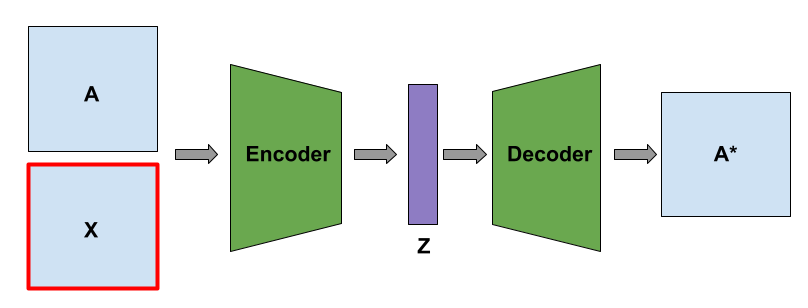

In [ ]:
#@title Model & Training Configuration

HIDDEN_SIZE = 200  #@param {type: "integer"}

OUT_CHANNELS = 20  #@param {type: "integer"}

EPOCHS =   40#@param {type: "integer"}

In [ ]:
class ARMAEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_size, out_channels, dropout):
        super(ARMAEncoder, self).__init__()
        self.conv1 = ARMAConv(in_channels, hidden_size) # cached only for transductive learning
        self.conv2 = ARMAConv(hidden_size, out_channels) # cached only for transductive learning
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index):
        x_temp1 = self.conv1(x, edge_index).relu()
        x_temp2 = self.dropout(x_temp1)
        return self.conv2(x_temp2, edge_index)
class FeaStEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_size, out_channels, dropout):
        super(FeaStEncoder, self).__init__()
        self.conv1 = FeaStConv(in_channels, hidden_size) # cached only for transductive learning
        self.conv2 = FeaStConv(hidden_size, out_channels) # cached only for transductive learning
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index):
        x_temp1 = self.conv1(x, edge_index).relu()
        x_temp2 = self.dropout(x_temp1)
        return self.conv2(x_temp2, edge_index)
class HypergraphEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_size, out_channels, dropout):
        super(HypergraphEncoder, self).__init__()
        self.conv1 = HypergraphConv(in_channels, hidden_size) # cached only for transductive learning
        self.conv2 = HypergraphConv(hidden_size, out_channels) # cached only for transductive learning
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index):
        x_temp1 = self.conv1(x, edge_index).relu()
        x_temp2 = self.dropout(x_temp1)
        return self.conv2(x_temp2, edge_index)
class DenseGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_size, out_channels, dropout):
        super(DenseGCNEncoder, self).__init__()
        self.conv1 = DenseGCNConv(in_channels, hidden_size) # cached only for transductive learning
        self.conv2 = DenseGCNConv(hidden_size, out_channels) # cached only for transductive learning
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index):
        x_temp1 = self.conv1(x, edge_index).relu()
        x_temp2 = self.dropout(x_temp1)
        return self.conv2(x_temp2, edge_index)
class DenseSAGEEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_size, out_channels, dropout):
        super(DenseSAGEEncoder, self).__init__()
        self.conv1 = DenseSAGEConv(in_channels, hidden_size) # cached only for transductive learning
        self.conv2 = DenseSAGEConv(hidden_size, out_channels) # cached only for transductive learning
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index):
        x_temp1 = self.conv1(x, edge_index).relu()
        x_temp2 = self.dropout(x_temp1)
        return self.conv2(x_temp2, edge_index)

class GraphEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_size, out_channels, dropout):
        super(GraphEncoder, self).__init__()
        self.conv1 = GraphConv(in_channels, hidden_size) # cached only for transductive learning
        self.conv2 = GraphConv(hidden_size, out_channels) # cached only for transductive learning
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index):
        x_temp1 = self.conv1(x, edge_index).relu()
        x_temp2 = self.dropout(x_temp1)
        return self.conv2(x_temp2, edge_index)
class ChebEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_size, out_channels, dropout):
        super(ChebEncoder, self).__init__()
        self.conv1 = ChebConv(in_channels, hidden_size,2) # cached only for transductive learning
        self.conv2 = ChebConv(hidden_size, out_channels,2) # cached only for transductive learning
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index):
        x_temp1 = self.conv1(x, edge_index).relu()
        x_temp2 = self.dropout(x_temp1)
        return self.conv2(x_temp2, edge_index)

class SGEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_size, out_channels, dropout):
        super(SGEncoder, self).__init__()
        self.conv1 = SGConv(in_channels, hidden_size) # cached only for transductive learning
        self.conv2 = SGConv(hidden_size, out_channels) # cached only for transductive learning
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index):
        x_temp1 = self.conv1(x, edge_index).relu()
        x_temp2 = self.dropout(x_temp1)
        return self.conv2(x_temp2, edge_index)

"""
class Encoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_size, out_channels, dropout):
        super(GCNEncoder, self).__init__()
        self.conv1 = Conv(in_channels, hidden_size) # cached only for transductive learning
        self.conv2 = Conv(hidden_size, out_channels) # cached only for transductive learning
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index):
        x_temp1 = self.conv1(x, edge_index).relu()
        x_temp2 = self.dropout(x_temp1)
        return self.conv2(x_temp2, edge_index)
"""
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_size, out_channels, dropout):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_size) # cached only for transductive learning
        self.conv2 = GCNConv(hidden_size, out_channels) # cached only for transductive learning
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index):
        x_temp1 = self.conv1(x, edge_index).relu()
        x_temp2 = self.dropout(x_temp1)
        return self.conv2(x_temp2, edge_index)



#gae_model = GAE(GCNEncoder(NUM_FEATURES, HIDDEN_SIZE, OUT_CHANNELS, 0.5))
#gae_model = GAE(ARMAEncoder(NUM_FEATURES, HIDDEN_SIZE, OUT_CHANNELS, dropout= 0.5))
#gae_model = GAE(FeaStEncoder(NUM_FEATURES, HIDDEN_SIZE, OUT_CHANNELS, dropout = 0.5))
#gae_model = GAE(HypergraphEncoder(NUM_FEATURES, HIDDEN_SIZE, OUT_CHANNELS, 0.5))
#gae_model = GAE(DenseGCNEncoder(NUM_FEATURES, HIDDEN_SIZE, OUT_CHANNELS, 0.5))
#gae_model = GAE(DenseSAGEEncoder(NUM_FEATURES, HIDDEN_SIZE, OUT_CHANNELS, 0.5))
#gae_model = GAE(ChebEncoder(NUM_FEATURES, HIDDEN_SIZE, OUT_CHANNELS, 0.5))
gae_model = GAE(GraphEncoder(NUM_FEATURES, HIDDEN_SIZE, OUT_CHANNELS, 0.5))
#gae_model = GAE(SGEncoder(NUM_FEATURES, HIDDEN_SIZE, OUT_CHANNELS, 0.5))
#gae_model = GAE(Encoder(NUM_FEATURES, HIDDEN_SIZE, OUT_CHANNELS, 0.5))

gae_model = gae_model.to(device)

# EncoderModel

In [ ]:
def gae_train(train_data, gae_model, optimizer):
    gae_model.train()
    optimizer.zero_grad()
    z = gae_model.encode(train_data.x, train_data.edge_index) # forward  alias  -ao
    loss = gae_model.recon_loss(z, train_data.pos_edge_label_index.to(device))
    loss.backward(retain_graph=True)
    optimizer.step()
    return float(loss)
@torch.no_grad()
def gae_test(test_data, gae_model):
    gae_model.eval()
    z = gae_model.encode(test_data.x, test_data.edge_index)
    return gae_model.test(z, test_data.pos_edge_label_index, test_data.neg_edge_label_index)

In [ ]:
visualize_tsne_embeddings(gae_model, train_dataset, 'Untrained GAE: train set embeddings t-SNE', labeled=True, labels=[40, 190, 230, 1830, 260, 110, 280, 1967])

In [ ]:
visualize_pca_embeddings(gae_model, train_dataset, 'Untrained GAE: train set embeddings PCA', labeled=True, labels=[40, 190, 230, 1830, 260, 110, 280, 1967])

#     Train
Now let's train the model! We keep track of a few scores at the end of each epoch. First is the loss obtained by the model. Next, we keep track of both training and test set performance. We measure the performance in terms of two metrics: the ROC-AUC score, and the Average Precision (AP) score.

In [ ]:
losses = []
test_auc = []
test_ap = []
train_aucs = []
train_aps = []


optimizer = torch.optim.Adam(gae_model.parameters(), lr=0.01)

for epoch in range(1, EPOCHS + 1):
    loss = gae_train(train_dataset, gae_model, optimizer)
    losses.append(loss)
    auc, ap = gae_test(test_dataset, gae_model)
    test_auc.append(auc)
    test_ap.append(ap)

    train_auc, train_ap = gae_test(train_dataset, gae_model)

    train_aucs.append(train_auc)
    train_aps.append(train_ap)
    print('Epoch: {:03d}, test AUC: {:.4f}, test AP: {:.4f}, train AUC: {:.4f}, train AP: {:.4f}, loss:{:.4f}'.format(epoch, auc, ap, train_auc, train_ap, loss))

Epoch: 001, test AUC: 0.5809, test AP: 0.5479, train AUC: 0.6687, train AP: 0.6036, loss:4.9005
Epoch: 002, test AUC: 0.5597, test AP: 0.5368, train AUC: 0.6755, train AP: 0.6088, loss:22.9832
Epoch: 003, test AUC: 0.5639, test AP: 0.5558, train AUC: 0.7122, train AP: 0.6408, loss:22.1512
Epoch: 004, test AUC: 0.6132, test AP: 0.6098, train AUC: 0.7746, train AP: 0.7104, loss:18.6758
Epoch: 005, test AUC: 0.6835, test AP: 0.7168, train AUC: 0.8375, train AP: 0.8176, loss:12.6403
Epoch: 006, test AUC: 0.7794, test AP: 0.7854, train AUC: 0.8512, train AP: 0.8515, loss:4.8966
Epoch: 007, test AUC: 0.7711, test AP: 0.7820, train AUC: 0.8426, train AP: 0.8487, loss:2.1908
Epoch: 008, test AUC: 0.7861, test AP: 0.7939, train AUC: 0.8451, train AP: 0.8531, loss:2.4158
Epoch: 009, test AUC: 0.8214, test AP: 0.8217, train AUC: 0.8619, train AP: 0.8660, loss:1.6684
Epoch: 010, test AUC: 0.8573, test AP: 0.8537, train AUC: 0.8790, train AP: 0.8823, loss:1.2387
Epoch: 011, test AUC: 0.9140, test A

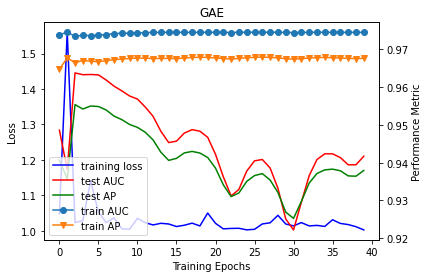

In [ ]:
plot_training_stats('GAE', losses, test_auc, test_ap, train_aucs, train_aps)

Best Threshold=0.585071


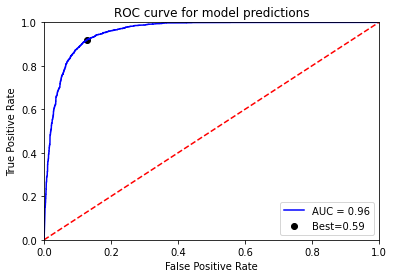

In [ ]:
plot_roc_curve(gae_model, test_dataset)

Finally, we can visualize the embeddings again -- this time, with the trained model.

In [ ]:
visualize_tsne_embeddings(
    gae_model, train_dataset, title='Trained GAE: train set embeddings',
    perplexity=5, labeled=True, labels=[40, 190, 230, 1830, 260, 110, 280, 1967])

In [ ]:
visualize_pca_embeddings(
    gae_model, train_dataset, title='Trained GAE: train set embeddings',
    labeled=True, labels=[40, 190, 230, 1830, 260, 110, 280, 1967])

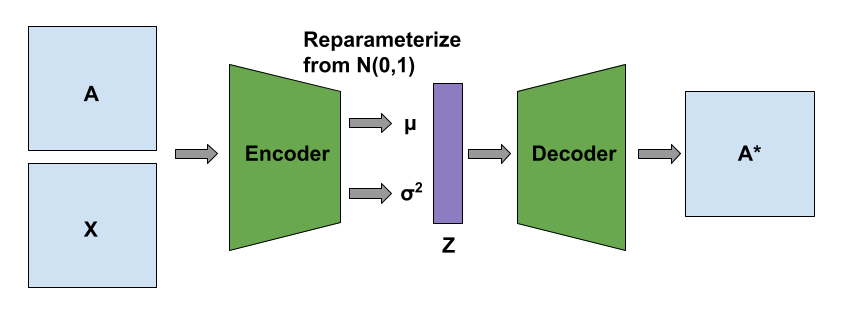

# Hyperparameter Tuning

In [ ]:
def perform_hyperparameter_search(model_type, param_grid, train_set, val_set, save_weights=False, early_stop=False):
  default = {'lr': [0.01],
            'hidden_dim': [150, 200, 250],
             'num_features': [5],
             'out_channels': [20],
             'dropout': [.2, .5],
             'max_epochs': [200, 300]}

  for arg in default:
    if arg not in param_grid:
      param_grid[arg] = default[arg]
  grid = ParameterGrid(param_grid)
  ap_results = {}
  auc_results = {}

  eid = 0 # experiment id
  for params in grid:
    # Index of the model, represents the parameters
    index = '; '.join(x + '_' + str(y) for x, y in params.items())
    print(index)

    # Launch a training experiment using the current set of parameters
    val_ap, val_auc = launch_experiment(eid,
                   model_type,
                   params,
                   train_set,
                   val_set,
                   save_weights=save_weights,
                   early_stop=early_stop)
    eid += 1
    ap_results[index] = val_ap
    auc_results[index] = val_auc
    print("Validation AP and AUC:", val_ap, val_auc)

  # Select the best results
  best_ap_index = max(ap_results, key = ap_results.get)
  best_ap_model = (best_ap_index, ap_results[best_ap_index])

  best_auc_index = max(auc_results, key = auc_results.get)
  best_auc_model = (best_auc_index, auc_results[best_auc_index])

  return best_ap_model, best_auc_model

def launch_experiment(eid, model_type, params, train_set, val_set, save_weights=False, early_stop=False):
  # Construct the features to be used.
  train_set.x = torch.ones(train_set.num_nodes, params['num_features'])
  val_set.x = torch.ones(val_set.num_nodes, params['num_features'])

  # Initialize model
  if model_type == 'GAE':
    model = GAE(GCNEncoder(params['num_features'], params['hidden_dim'], params['out_channels'], params['dropout']))
  elif model_type == 'VGAE':
    model = VGAE(VariationalGCNEncoder(params['num_features'], params['hidden_dim'], params['out_channels'], params['dropout']))
  else:
    print("Unsupported model_type: must be GAE or VGAE")
    return

  model = model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])

  prev_train_loss = 0.1 # Set to a small non-zero value
  for epoch in range(params['max_epochs']):
    train_loss = train(model_type, model, optimizer, train_set)
    val_ap, val_auc = test(model, val_set)

    # we can also add logic here to save the weights of the model if this current epoch
    # gives the best performance so far. Mostly passing in eid to construct a filename
    # for saving the model weights.

    if early_stop:
      loss_delta = abs(train_loss - prev_train_loss)
      # Stop criteria:
      # loss changing <10% from previous epoch
      # we can also add a criteria like
      # validation ap less than train ap by more than 0.3.
      # the second criteria suggests the gap is large between train/valid results
      # meaning we could be overfitting if we continue.
      if loss_delta / prev_train_loss < 0.1:
        break

  return val_ap, val_auc

def train(model_type, model, optimizer, train_set):
  model.train()
  optimizer.zero_grad()
  z = model.encode(train_set.x, train_set.edge_index)
  if model_type == 'GAE':
    loss = model.recon_loss(z, train_set.edge_index)
  elif model_type == 'VGAE':
    loss = model.recon_loss(z, train_set.edge_index) + (1 / train_set.num_nodes) * model.kl_loss()
  else:
    print("Unsupported model_type: must be GAE or VGAE")
    return
  loss.backward()
  optimizer.step()
  return float(loss)

@torch.no_grad()
def test(model, test_set):
  model.eval()
  z = model.encode(test_set.x, test_set.edge_index)
  return model.test(z, test_set.pos_edge_label_index, test_set.neg_edge_label_index)


In [ ]:
param_grid = {
    'lr': [0.01],
    'hidden_dim': [200],
    'num_features': [40],
    'out_channels': [15, 20,35 ,45],
    'dropout': [0.7],
    'max_epochs': [100],
}
best_ap_model, best_auc_model = perform_hyperparameter_search('VGAE', param_grid, train_dataset, val_dataset)
print("Best AP Model:", best_ap_model)
print("Best AUC Model:", best_auc_model)

dropout_0.7; hidden_dim_200; lr_0.01; max_epochs_100; num_features_40; out_channels_15
Validation AP and AUC: 0.9392479857073719 0.9338010417533038
dropout_0.7; hidden_dim_200; lr_0.01; max_epochs_100; num_features_40; out_channels_20
Validation AP and AUC: 0.9359910372432232 0.9313164322544322
dropout_0.7; hidden_dim_200; lr_0.01; max_epochs_100; num_features_40; out_channels_35
Validation AP and AUC: 0.930058612775354 0.9263626810831636
dropout_0.7; hidden_dim_200; lr_0.01; max_epochs_100; num_features_40; out_channels_45
Validation AP and AUC: 0.9335843385399418 0.9292600853696539
Best AP Model: ('dropout_0.7; hidden_dim_200; lr_0.01; max_epochs_100; num_features_40; out_channels_15', 0.9392479857073719)
Best AUC Model: ('dropout_0.7; hidden_dim_200; lr_0.01; max_epochs_100; num_features_40; out_channels_15', 0.9338010417533038)


In [ ]:
# This table (downloaded and uploaded from Ensembl BioMart site) acts as a mapping that
# maps ENSEMBL Gene Ids to the NCBI Gene Ids used by the Gene-Disease Assoc
# dataset that we are using.
gene_url = "https://drive.google.com/uc?export=download&id=1JlptlMtfZvholERGLoP0w22nMBM6LpAW"
download_url(gene_url, '.')
!mv ./uc ./gene_ids.tsv

gene_ids_data_path = "./gene_ids.tsv"

gene_ids_df = pd.read_csv(gene_ids_data_path, sep="\t")
gene_ids_df = gene_ids_df.rename(columns={
    "Gene stable ID": "ENSEMBL Gene ID",
    "Gene stable ID version": "ENSEMBL Gene ID Version",
    "NCBI gene (formerly Entrezgene) ID": "Gene ID"})
gene_ids_df = gene_ids_df.loc[:, ["ENSEMBL Gene ID", "Gene ID"]]

# Add new "ENSEMBL Gene ID" column to our existing Gene-Disease Assoc table.
new_df = pd.merge(df, gene_ids_df, left_on="Gene ID", right_on="Gene ID", how="left")
new_df["Gene ID"] = new_df["Gene ID"].astype(int)
print(new_df.loc[:, ["Gene ID", "ENSEMBL Gene ID", ]])  # To confirm mapping.


# Check how many NCBI Gene IDs were unable to be mapped to ENSEMBL Genes IDs.
print("Number of unmapped NCBI Genes:",
      new_df.drop_duplicates(subset="Gene ID")['ENSEMBL Gene ID'].isna().sum())

       Gene ID  ENSEMBL Gene ID
0         1462  ENSG00000038427
1         1612  ENSG00000196730
2          182  ENSG00000101384
3         2011  ENSG00000072518
4         2019  ENSG00000163064
...        ...              ...
25309     8848  ENSG00000102804
25310     9076  ENSG00000163347
25311      947  ENSG00000174059
25312     9839  ENSG00000169554
25313      999  ENSG00000039068

[25314 rows x 2 columns]
Number of unmapped NCBI Genes: 382


Now that we have the ENSEMBL gene ids for each gene, we can use the **GeneSynopsis** dataset to look up the description for each gene in our dataset. We add these descriptions as another column to our input dataset's dataframe.

In [ ]:
# Download the GeneSynopysis dataset directly from the BioSNAP site.
url = 'https://snap.stanford.edu/biodata/datasets/10022/files/G-SynMiner_miner-geneHUGO.tsv.gz'
extract_gz(download_url(url, '.'), '.')

# This table contains info on a select set of genes, with each gene identified
# via their ENSEMBL Gene Id or HGNC Id. We would like to use the "name" as the
# short description of the gene.
data_path = "./G-SynMiner_miner-geneHUGO.tsv.gz"
genes_df = pd.read_csv(data_path, sep="\t")
# print('\n', genes_df.loc[:,["# ensembl_gene_id", "name"]])

# Add the appropriate "name" data to the dataframe for each gene.
full_df = pd.merge(
    new_df, genes_df, left_on="ENSEMBL Gene ID",
    right_on="# ensembl_gene_id", how="left")

# Cut out any extraneous columns from the data frame and rename for easier use.
full_df = full_df.loc[:, ['# Disease ID', 'Disease Name', 'Gene ID', 'name']]
full_df = full_df.rename(columns={
    '# Disease ID': "Disease ID",
    'Disease Name': "Disease Name",
    'Gene ID': "Gene ID",
    'name': "Gene Name",
})

# print(full_df)
# print(full_df.columns)
print("Gene ID <-> Gene Name:\n", full_df.loc[:, ["Gene ID", "Gene Name"]], '\n')

num_nan_ensembl = new_df.drop_duplicates(subset="Gene ID")['ENSEMBL Gene ID'].isna().sum()
num_nan_desc = full_df.drop_duplicates(subset="Gene ID")["Gene Name"].isna().sum()
print("Number of missing ENSEMBL Gene IDs:", num_nan_ensembl)
print("Number of missing gene names:", num_nan_desc)

# Use model to look at predictions


In [ ]:
# Select particular model and dataset
data_object_to_analyze = data_object
model_to_analyze = gae_model

print("DataObject:\n", data_object_to_analyze)
print("\nModel:\n", model_to_analyze)

DataObject:
 Data(num_nodes=7813, edge_index=[2, 42714], x=[7813, 128])

Model:
 GAE(
  (encoder): GraphEncoder(
    (conv1): GraphConv(128, 200)
    (conv2): GraphConv(200, 20)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): InnerProductDecoder()
)


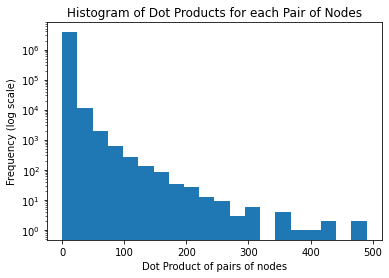

In [ ]:
# Get ranked edge list, filtered by the selected node ids.
ranked_edge_list, ranked_dot_products = get_ranked_edges(data_object_to_analyze, model_to_analyze)

# Plot histogram of the dot products
plt.hist(ranked_dot_products, bins=20)
plt.title("Histogram of Dot Products for each Pair of Nodes")
plt.yscale('log', nonposy='clip')
plt.ylabel("Frequency (log scale)")
plt.xlabel("Dot Product of pairs of nodes")
plt.show()

In [ ]:
# Select for particular examples
select_gene_substrings = [".*"]
select_disease_substrings = ['retina|retinitis']

In [ ]:
# Filter data frame by the selected disease terms, and get their node ids.
if select_disease_substrings:
  dz_regex = "(?i)" + "|".join(select_disease_substrings)
  query_df = full_df[full_df['Disease Name'].str.contains(dz_regex)]
  query_dz_nodes = [dz_mapping[dz_id] for dz_id in query_df['Disease ID'].drop_duplicates().tolist()]
  # print("\nQueried Disease Nodes:\n", query_df['Disease Name'])
else:
  query_dz_nodes = None

# Filter data frame by the selected gene terms, and get their node ids.
if select_gene_substrings:
  gene_regex = "(?i)" + "|".join(select_gene_substrings)
  query_df = full_df[full_df['Gene Name'].notna()]
  query_df = query_df[query_df['Gene Name'].str.contains(gene_regex)]
  query_gene_nodes = [gene_mapping[gene_id] for gene_id in query_df['Gene ID'].drop_duplicates().tolist()]
  # print("\nQueried Gene Nodes:\n", query_df['Gene Name'])
else:
  query_gene_nodes = None


# Get reverse dz and gene mappings, to print out all needed info.
reverse_dz_mapping = {j: i for i,j in dz_mapping.items()}
reverse_gene_mapping = {j: i for i,j in gene_mapping.items()}

print("\nTop Predicted Edges")
top_k = 50
curr_k = 0
for dz_i, gene_i in ranked_edge_list:
  # Skip edges that do not include the selected dz and gene nodes
  if query_dz_nodes and dz_i not in query_dz_nodes:
    continue
  if query_gene_nodes and gene_i not in query_gene_nodes:
    continue

  # Get all the info needed (dz_i and gene_i are the node indeces)
  dz_id, gene_id = reverse_dz_mapping[dz_i], reverse_gene_mapping[gene_i]
  dz_description = full_df[full_df["Disease ID"] == dz_id]["Disease Name"].drop_duplicates().iloc[0]
  gene_description = full_df[full_df["Gene ID"] == gene_id]["Gene Name"].drop_duplicates().iloc[0]
  dot_product = ranked_dot_products[curr_k]

  print('edge=({},{}), \t dotprod={:.2f},\t descriptions=({},{})'.format(dz_i, gene_i, dot_product, dz_description, gene_description))

  curr_k += 1
  if curr_k > top_k:
    break


Top Predicted Edges
edge=(169,655), 	 dotprod=490.25,	 descriptions=(Retinitis Pigmentosa,TNF alpha induced protein 3)
edge=(169,578), 	 dotprod=473.88,	 descriptions=(Retinitis Pigmentosa,calcium/calmodulin dependent protein kinase II beta)
edge=(169,715), 	 dotprod=433.57,	 descriptions=(Retinitis Pigmentosa,S100 calcium binding protein A12)
edge=(169,623), 	 dotprod=419.06,	 descriptions=(Retinitis Pigmentosa,interleukin 12B)
edge=(169,657), 	 dotprod=407.14,	 descriptions=(Retinitis Pigmentosa,tyrosine kinase 2)
edge=(169,621), 	 dotprod=379.99,	 descriptions=(Retinitis Pigmentosa,interleukin 4)
edge=(169,973), 	 dotprod=367.45,	 descriptions=(Retinitis Pigmentosa,neutrophil cytosolic factor 2)
edge=(169,692), 	 dotprod=366.75,	 descriptions=(Retinitis Pigmentosa,NPHS2 podocin)
edge=(169,867), 	 dotprod=360.04,	 descriptions=(Retinitis Pigmentosa,interferon, alpha 2)
edge=(169,1091), 	 dotprod=355.35,	 descriptions=(Retinitis Pigmentosa,erb-b2 receptor tyrosine kinase 2)
edge=(169